In [ ]:
import os
from pathlib import Path
from PIL import Image
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.ndimage import gaussian_filter

import torch
import torch.nn.functional as F
from torch import nn
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from google.colab import drive
drive.mount('/content/drive')

DATA_ROOT = "/content/drive/MyDrive/Colab Notebooks/Anomaly_detection/Data/MvTec"

Mounted at /content/drive


In [ ]:
# load WRN-50-2:
model = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=True)
model.cuda()
model.eval()

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        if name not in activation:
            activation[name] = torch.tensor([])
        activation[name] = torch.cat((activation[name], output.detach().cpu()))
    return hook

model.layer1.register_forward_hook(get_activation('layer1'))
model.layer2.register_forward_hook(get_activation('layer2'))
model.layer3.register_forward_hook(get_activation('layer3'))
model.avgpool.register_forward_hook(get_activation('avgpool'))

### Normal Dataset

In [ ]:
class BrainDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.data = image_paths

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = Image.open(self.data[idx])

        if self.transform:
            image = self.transform(image)

        return image

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# MVTec metal_nut class
train_paths = list(sorted(Path(DATA_ROOT + "/metal_nut/train/good").glob("./*.png")))
test_paths = list(sorted(Path(DATA_ROOT + "/metal_nut/test/color").glob("./*.png")))[:3] + list(sorted(Path(DATA_ROOT + "/metal_nut/test/good").glob("./*.png")))[:2]

train_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', []), ('avgpool', [])])
test_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', []), ('avgpool', [])])

trainset = BrainDataset(train_paths, transform=preprocess)
train_dataloader = DataLoader(trainset, batch_size=32, shuffle=True)

testset = BrainDataset(test_paths, transform=preprocess)
test_dataloader = DataLoader(testset, batch_size=32, shuffle=False)

### Fetures of Normal Class

In [ ]:
activation = {}
for x in tqdm(train_dataloader, position =0):
    model(x.cuda())

for layer in ['layer1', 'layer2', 'layer3', 'avgpool']:
    train_outputs[layer] = activation[layer]

for layer in ['layer1', 'layer2', 'layer3', 'avgpool']:
    print(train_outputs[layer].size())

100%|██████████| 7/7 [01:04<00:00,  9.22s/it]

torch.Size([220, 256, 56, 56])
torch.Size([220, 512, 28, 28])
torch.Size([220, 1024, 14, 14])
torch.Size([220, 2048, 1, 1])


### Features of abnormal

In [ ]:
activation = {}
for x in tqdm(test_dataloader, position =0):
    model(x.cuda())

for layer in ['layer1', 'layer2', 'layer3', 'avgpool']:
    test_outputs[layer] = activation[layer]

for layer in ['layer1', 'layer2', 'layer3', 'avgpool']:
    print(test_outputs[layer].size())

100%|██████████| 1/1 [00:02<00:00,  2.43s/it]

torch.Size([5, 256, 56, 56])
torch.Size([5, 512, 28, 28])
torch.Size([5, 1024, 14, 14])
torch.Size([5, 2048, 1, 1])


### K Nearest Neighbor Normal Image Retrieval
https://github.com/byungjae89/SPADE-pytorch/blob/077c67be21d68a38b4442db7311c87e708728286/src/main.py#L110C9-L112C83

In [ ]:
def calc_dist_matrix(x, y):
    """Calculate Euclidean distance matrix with torch.tensor"""
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    # print(x.size())
    # print(y.size())
    # print("--")
    # print(x.unsqueeze(1).size())
    # print(y.unsqueeze(0).size())
    # print("--")
    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)
    # print(x.size())
    # print(y.size())
    # print("--")
    #print(torch.equal(x[:, 0], x[:, 1]))
    dist_matrix = torch.sqrt(torch.pow(x - y, 2).sum(2))
    return dist_matrix

dist_matrix = calc_dist_matrix(torch.flatten(test_outputs['avgpool'], 1), torch.flatten(train_outputs['avgpool'], 1))

print("dist_matrix.size()", list(dist_matrix.size()))

# K nearest neighbors
K = 5

values, indicies = torch.topk(dist_matrix, K, largest=False, dim=1)
print("image anomaly scores:", torch.mean(values, dim=1))

dist_matrix.size() [5, 220]
image anomaly scores: tensor([7.3719, 7.4470, 7.6035, 6.6229, 7.3368])


### Sub-image Anomaly Detection via Image Alignment

In [ ]:
score_map_list = []
for i in tqdm(range(test_outputs['avgpool'].size()[0]), position=0):

    score_map_layer = []

    for layer in ['layer1', 'layer2', 'layer3']:

        # Create gallery for test image i
        topk_gallery = train_outputs[layer][indicies[i]].transpose(3, 1).transpose(1, 2).flatten(0, 2)
        # Get test feature map
        test_feat = test_outputs[layer][i].transpose(2, 0).transpose(0, 1).flatten(0, 1)

#         print(topk_gallery.size())
#         print(test_feat.size())

        # k = 1
        score_map = torch.tensor([])
        N = 100
        for j in range(len(topk_gallery)//N + 1):

            x = test_feat
            y = topk_gallery[100*j:100*(j+1)]

#             print(x.size())
#             print(y.size())

            n = x.size()[0]
            m = y.size()[0]
            d = y.size()[1]

            x = x.unsqueeze(1)
            y = y.unsqueeze(0)

#             print(x.size())
#             print(y.size())

            x = x.expand(n, m, d)
            y = y.expand(n, m, d)

#             if j == len(topk_gallery)//N:
#                 print(x.size())
#                 print(y.size())

#                 print(score_map.size())

            dist = torch.sqrt(torch.sum((x - y) ** 2, axis=-1))
            score_map = torch.cat((dist, score_map), dim=1)

#         print(score_map.size())
#         print(torch.min(score_map, dim=0).values.size())
        score_map_layer.append(torch.min(score_map, dim=1).values)

    score_map_list.append(score_map_layer)



  0%|          | 0/5 [00:38<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
len(score_map_list)

5

** layer 1
after interpolation


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


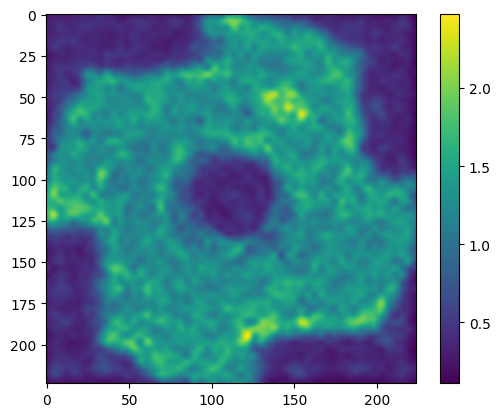

** layer 2
after interpolation


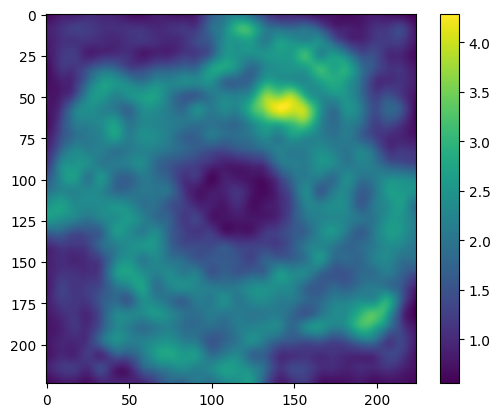

** layer 3
after interpolation


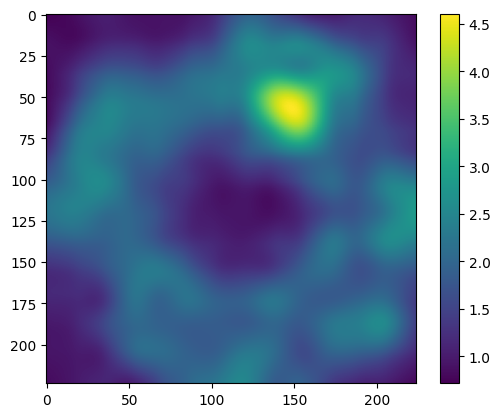

** layer 1
after interpolation


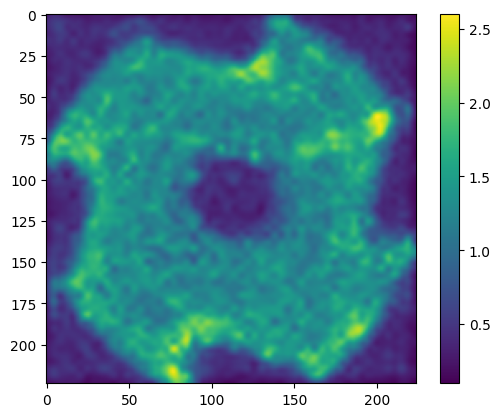

** layer 2
after interpolation


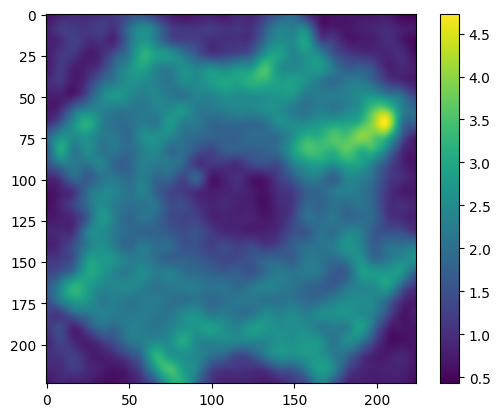

** layer 3
after interpolation


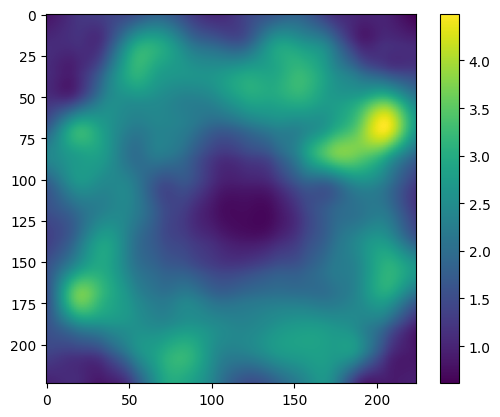

** layer 1
after interpolation


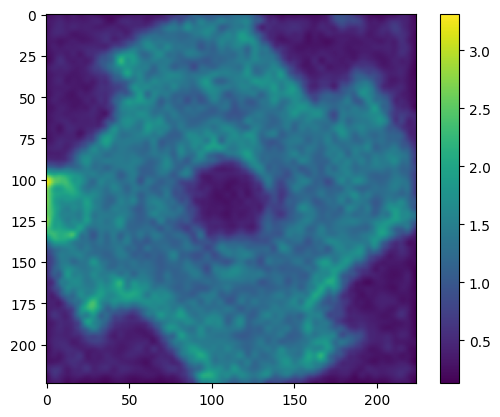

** layer 2
after interpolation


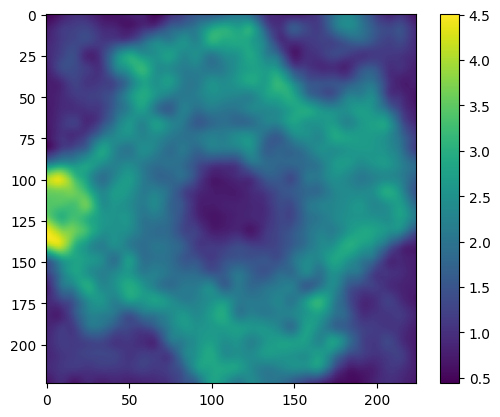

** layer 3
after interpolation


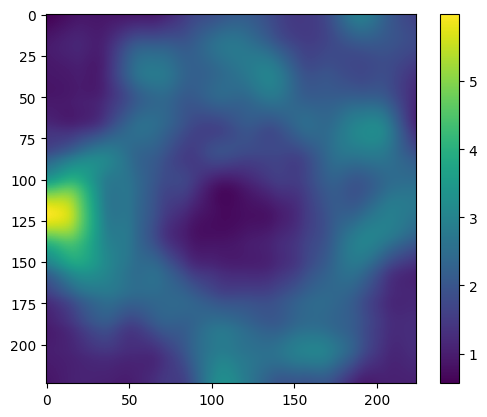

** layer 1
after interpolation


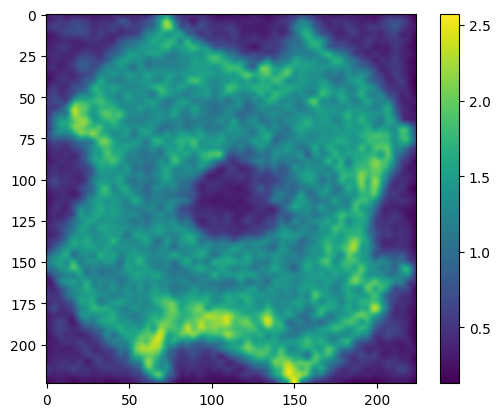

** layer 2
after interpolation


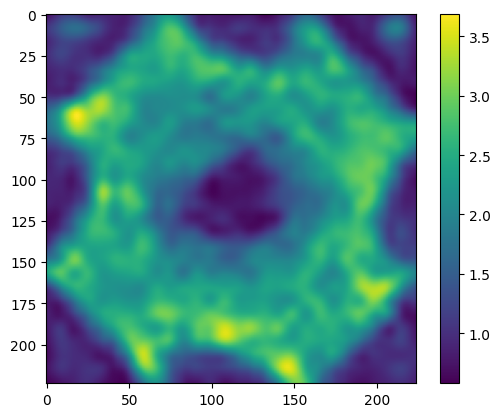

** layer 3
after interpolation


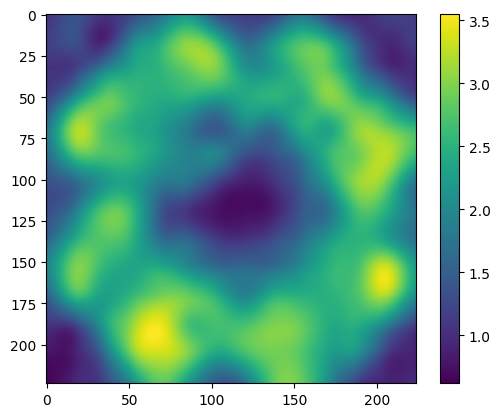

** layer 1
after interpolation


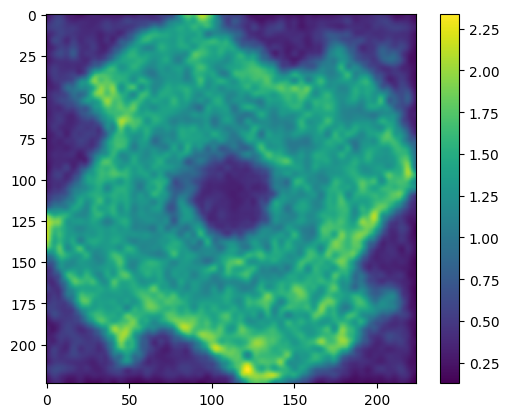

** layer 2
after interpolation


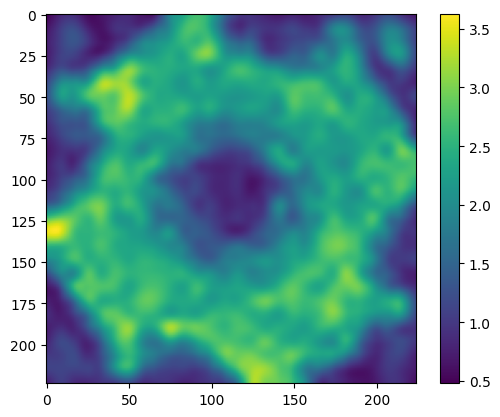

** layer 3
after interpolation


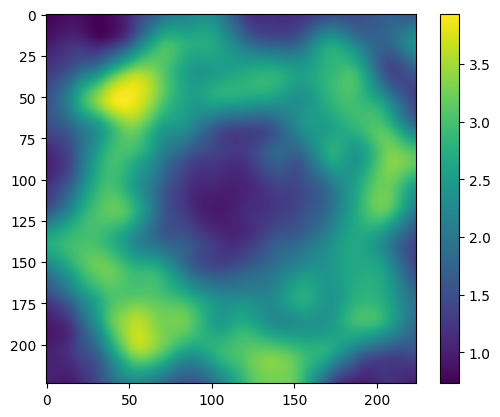

In [ ]:
interpolated_maps = torch.zeros((len(score_map_list), 3, 224, 224))
layer_names = ['layer1', 'layer2', 'layer3']
for i in range(len(score_map_list)):
    interpolated_layer = torch.tensor([])
    for j, layer in enumerate(score_map_list[i]):
        print("** layer", j+1)
        size = test_outputs[layer_names[j]].size()[-2:]
        result = torch.squeeze(F.interpolate(layer.resize(*size).unsqueeze(0).unsqueeze(0), size=224,mode='bicubic', align_corners=True))

        interpolated_layer = torch.cat((interpolated_layer, result.unsqueeze(0)))
        print("after interpolation")
        plt.imshow(result)
        plt.colorbar()
        plt.show()

    interpolated_maps[i] = interpolated_layer

In [ ]:
def overlay_heatmap_on_image(img, heatmap, ratio_img=0.5):
    img = img.astype(np.float32)

    heatmap = 1 - np.clip(heatmap, 0, 1)
    heatmap = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap = heatmap.astype(np.float32)

    overlay = (img * ratio_img) + (heatmap * (1 - ratio_img))
    overlay = overlay.astype(np.uint8)
    overlay = np.clip(overlay, 0, 255)
    return overlay

---
defect


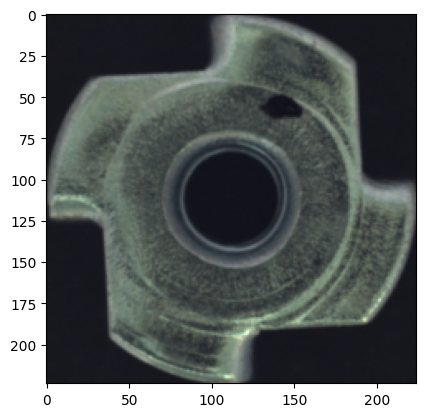

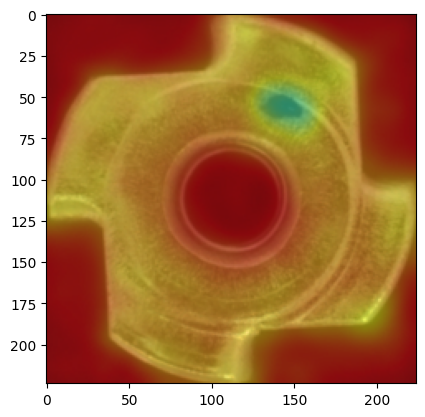

---
defect


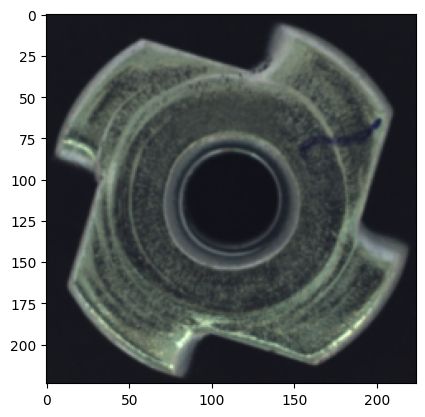

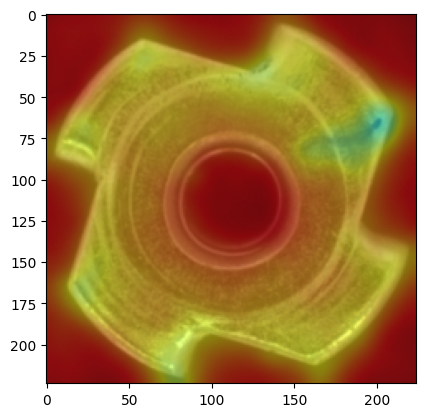

---
defect


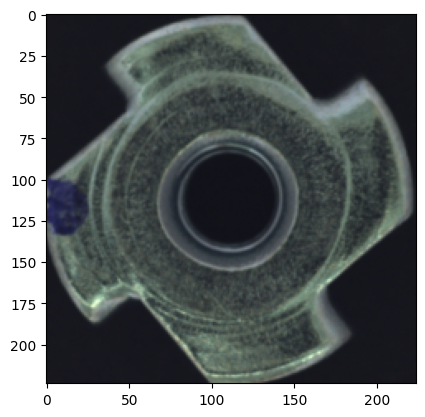

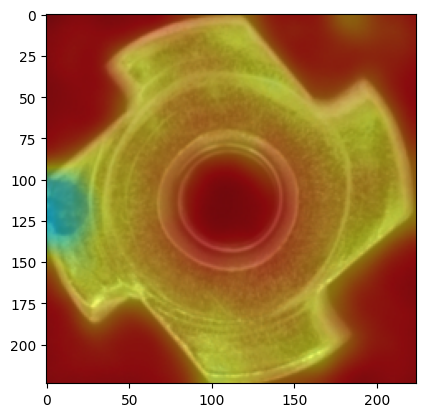

---
good


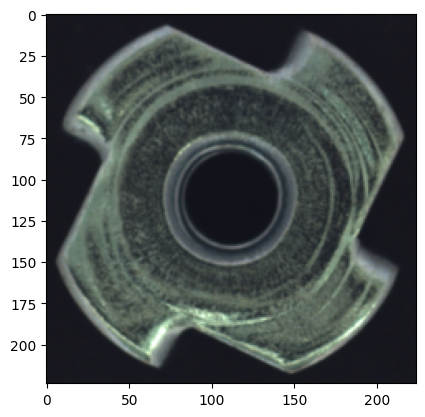

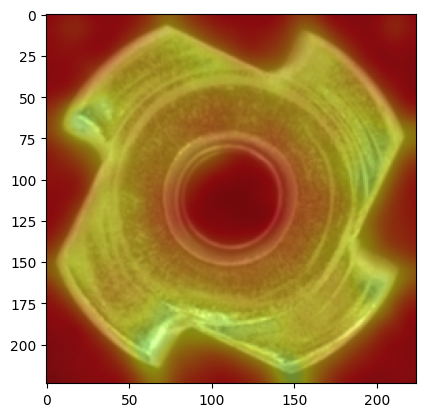

---
good


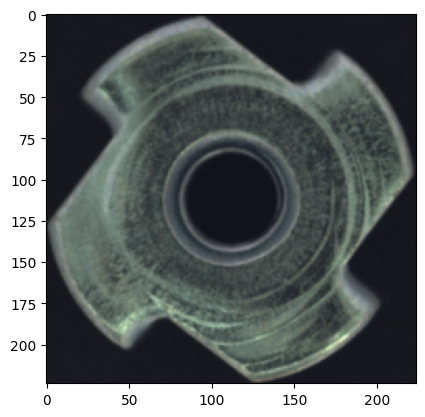

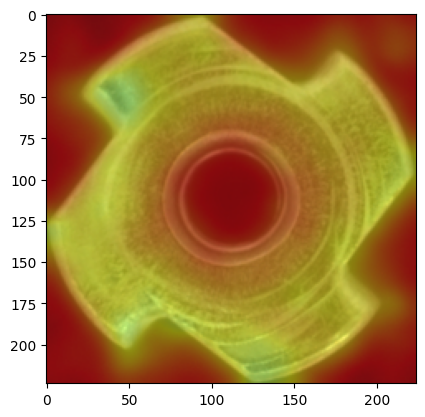

In [ ]:
# https://github.com/gsurma/cnn_explainer/blob/main/utils.py#L16
def overlay_heatmap_on_image(img, heatmap, alpha):
    new_img = img.astype(np.float32)

    new_heatmap = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET).astype(np.float32)

    beta =  1-alpha
    overlay = cv2.addWeighted(new_heatmap, alpha, new_img, beta, 0).astype(np.uint8)
    return overlay



for i in range(len(interpolated_maps)):
    print("---")
    if i < 3:
      print("defect")
    else:
      print("good")
    score_map_ = torch.mean(interpolated_maps[i], dim=0)
    score_map_ = gaussian_filter(score_map_, sigma=4)

    score_map_ = score_map_ - torch.min(interpolated_maps).item()
    score_map_ = score_map_ / torch.max(interpolated_maps).item()


    col_preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        ])

    col_anomaly = col_preprocess(Image.open(test_paths[i])).permute(1, 2, 0).numpy() * 255

    plt.imshow(np.clip(col_anomaly.astype(np.uint8), 0, 255))
    plt.show()

    plt.imshow(overlay_heatmap_on_image(col_anomaly, score_map_, alpha=0.5))
    plt.show()

https://github.com/byungjae89/SPADE-pytorch/blob/master/src/main.py